Show how tiles that ought to be similar differ. Use a pretrained model (e.g. SwAV/SimCLR), calculate the nearest neighboars of the embeddings and show corresponding tiles of nearest embeddings.

Inspiration is drawn from https://docs.lightly.ai/self-supervised-learning/tutorials/package/tutorial_simclr_clothing.html

In [1]:
from pathlib import Path
from PIL import Image

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from lightly.data import LightlyDataset
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor
from tqdm import tqdm

from dpat.data import PMCHHGImageDataset
from dpat.extract_features.models import SwAV

/scistor/guest/sjg203/.conda/envs/pmchhg/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = SwAV.load_from_checkpoint(
    "/scistor/guest/sjg203/projects/pmc-hhg/dpat/checkpoints/swav-epoch=199-step=39200.ckpt"
)
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
fold = "val"
root_dir = "/scistor/guest/sjg203/projects/pmc-hhg/images-tif"
dataset = LightlyDataset.from_torch_dataset(
    PMCHHGImageDataset(
        root_dir=root_dir,
        image_paths_and_targets="/scistor/guest/sjg203/projects/pmc-hhg/images-tif/"
        "splits/"
        "medulloblastoma+pilocytic-astrocytoma_"
        f"pmc-hhg_{fold}-subfold-0-fold-0.csv",
        mpp=0.2,
        tile_size_x=224,
        tile_size_y=224,
        tile_overlap_x=0,
        tile_overlap_y=0,
        tile_mode="overflow",
        crop=False,
        mask_factory="no_mask",
        mask_foreground_threshold=None,
        mask_root_dir=None,
        transform=Compose([ToTensor()]),
    )
)
val_dataloader = DataLoader(dataset, batch_size=32)

In [4]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    with torch.no_grad():
        for img, _, _ in tqdm(dataloader, total=len(val_dataloader), desc="Extracting features"):
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)

    embeddings = torch.cat(embeddings, 0)
    embeddings = F.normalize(embeddings)
    return embeddings


model.eval()
embeddings = generate_embeddings(model, val_dataloader)

Extracting features: 100%|██████████| 657/657 [00:38<00:00, 16.85it/s]


In [5]:
def plot_knn_examples(embeddings, dataset, samples_idx = None, n_neighbors=10, num_examples=10):
    """Plots multiple rows of random images with their nearest neighbors."""
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # Get random samples
    if samples_idx is None:
        samples_idx = torch.randint(len(indices), size=(num_examples,))

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure(figsize=(n_neighbors, 1))

        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            neighbour_sample = dataset[neighbor_idx]
            metadata = dataset.dataset.get_metadata(neighbor_idx)
            ax.imshow(torch.permute(neighbour_sample[0], (1, 2, 0)))
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            ax.text(0.5,-0.3, metadata["case_id"].split("_")[-1], size=12, ha="center", transform=ax.transAxes)
            ax.axis('off')
    
    return samples_idx

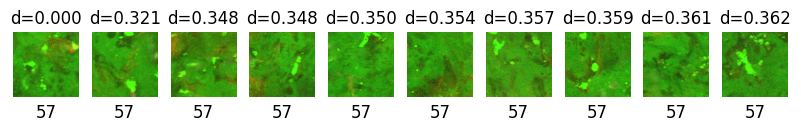

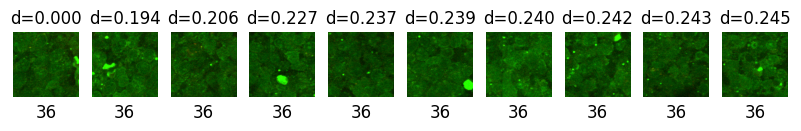

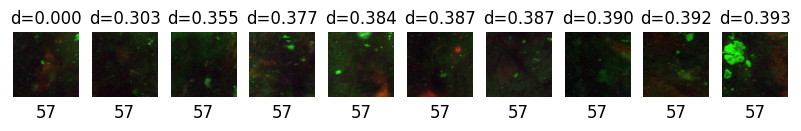

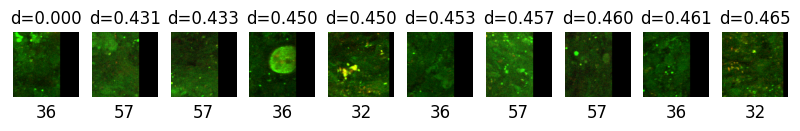

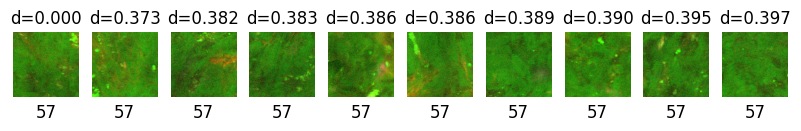

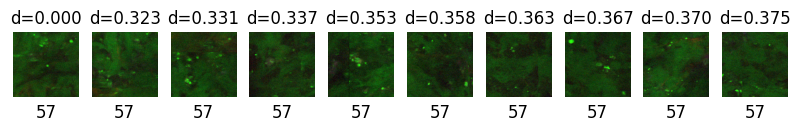

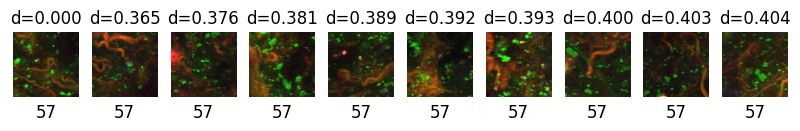

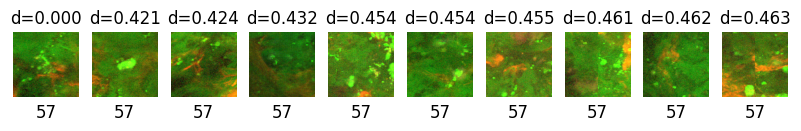

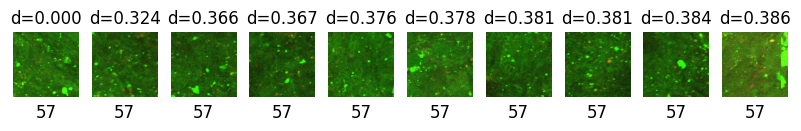

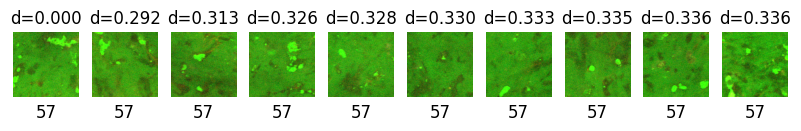

In [6]:
samples_idx = plot_knn_examples(embeddings.cpu(), dataset)

Compare with an untrained model.

Extracting features: 100%|██████████| 657/657 [00:30<00:00, 21.22it/s]


tensor([17915, 15646, 14370, 14905, 17603, 12384,  8394, 19386,  5665, 17057])

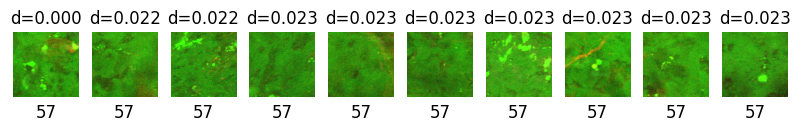

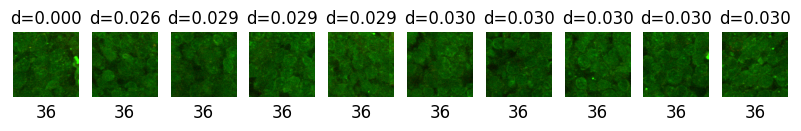

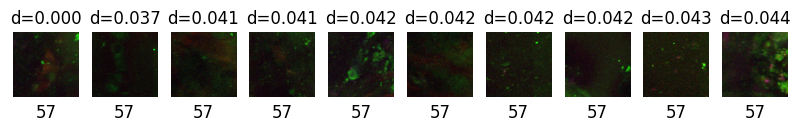

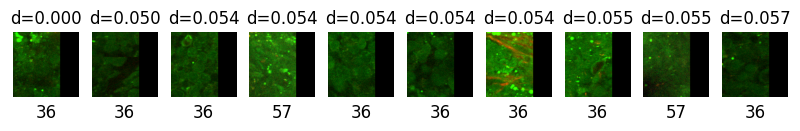

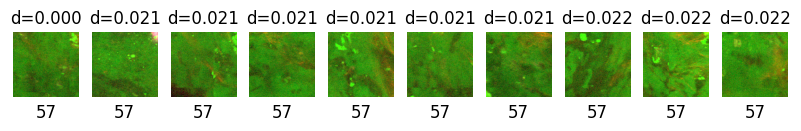

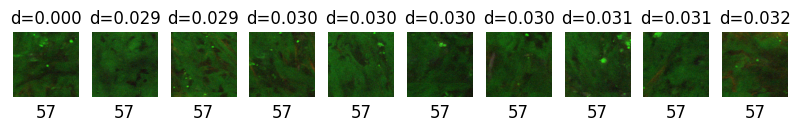

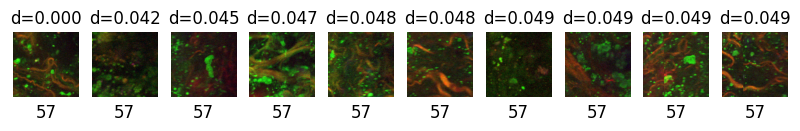

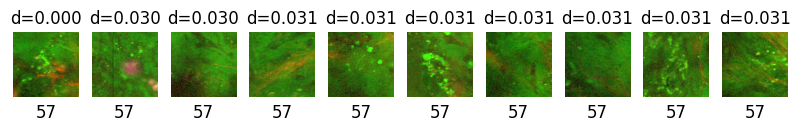

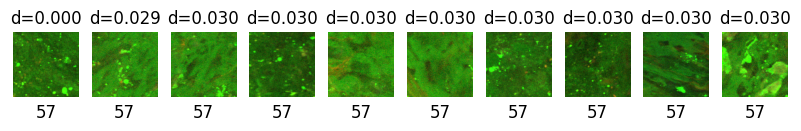

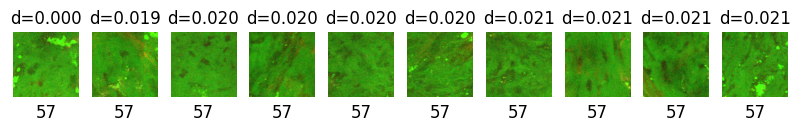

In [8]:
model = SwAV()
model = model.to("cuda" if torch.cuda.is_available() else "cpu")
model.eval()
embeddings = generate_embeddings(model, val_dataloader)
plot_knn_examples(embeddings.cpu(), dataset, samples_idx)